In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Barents = pd.read_excel(filepath, sheet_name='Barents-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Barents)
fp.date_time(Barents)

,Extent,Date
0,1107873.946,1979-01-01
1,1211101.473,1979-02-01
2,1215128.770,1979-03-01
3,1233940.811,1979-04-01
4,1193061.566,1979-05-01
...,...,...
533,124025.343,2023-06-01
534,53107.426,2023-07-01
535,11242.827,2023-08-01
536,3272.024,2023-09-01


In [5]:
scaler = MinMaxScaler()
Barents['Extent'] = scaler.fit_transform(Barents['Extent'].values.reshape(-1, 1))

In [6]:
extent = Barents['Extent']
W_S=12
X,y = fp.df_to_X_y(extent, W_S)
X.shape, y.shape

((526, 12, 1), (526,))

In [7]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [8]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Barents_model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [9]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 19s 228ms/step - loss: 0.1789 - root_mean_squared_error: 0.4229 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2204
Epoch 2/50
53/53 [==============================] - 11s 208ms/step - loss: 0.0836 - root_mean_squared_error: 0.2891 - val_loss: 0.0459 - val_root_mean_squared_error: 0.2142
Epoch 3/50
53/53 [==============================] - 9s 179ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396 - val_loss: 0.0411 - val_root_mean_squared_error: 0.2028
Epoch 4/50
53/53 [==============================] - 11s 204ms/step - loss: 0.0492 - root_mean_squared_error: 0.2218 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944
Epoch 5/50
53/53 [==============================] - 10s 199ms/step - loss: 0.0396 - root_mean_squared_error: 0.1989 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1733
Epoch 6/50
53/53 [==============================] - 11s 213ms/step - loss: 0.0321 - root_mean_squared_error: 0.1793 - val_loss: 0.0260 -

In [10]:
time = (etime - stime)/60
print(f'{time} minutes')

4.26390882730484 minutes


In [11]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

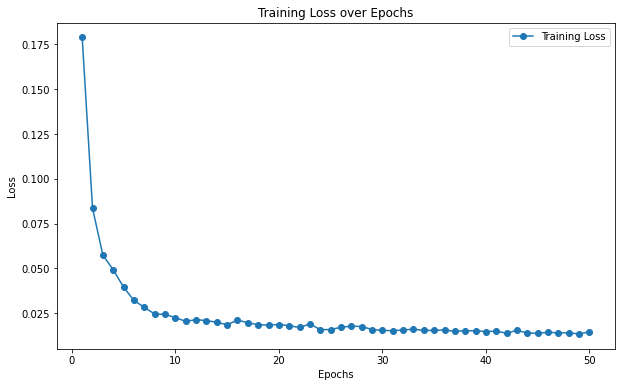

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

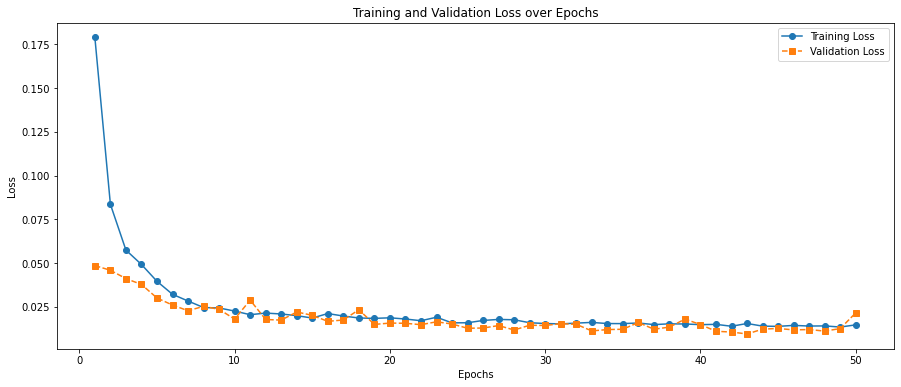

In [13]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [8]:
from tensorflow.keras.models import load_model
model1 = load_model('Barents_model/')

In [9]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 10ms/step


In [10]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.081159209315896
MAE : 0.06284186244453521


In [11]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [12]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,458296.656250,440856.132
1,251096.484375,265975.112
2,112255.445312,112300.019
3,45066.902344,44787.893
4,9169.954102,14909.156
5,32686.560547,54595.378
6,138412.796875,242829.930
7,294931.062500,406860.687
8,465921.593750,605897.837
9,577383.937500,654073.790


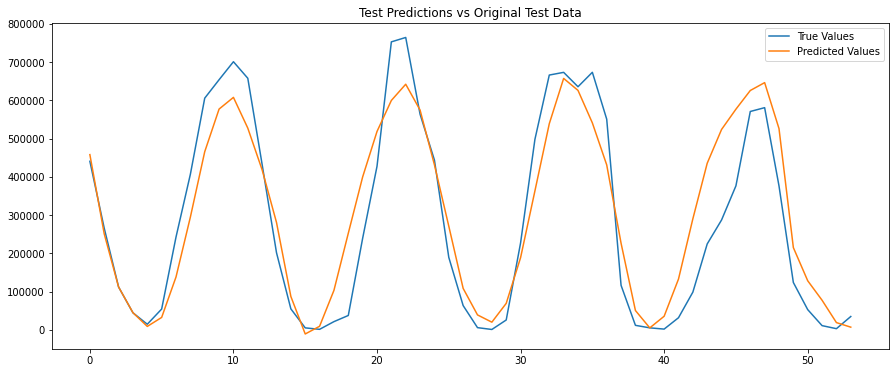

In [13]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [14]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 10ms/step


In [17]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

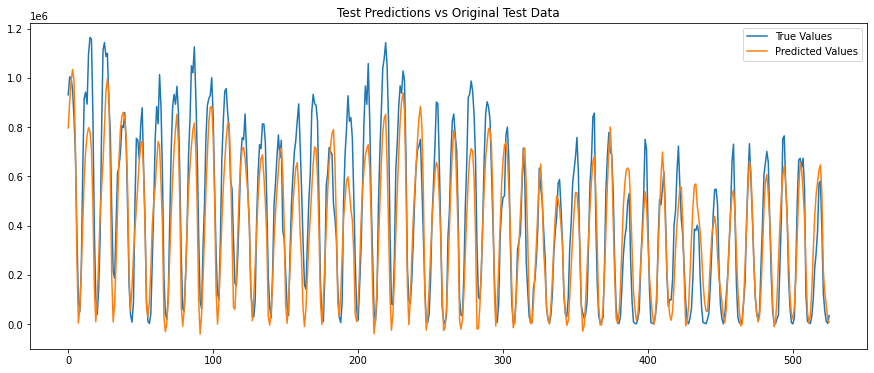

In [18]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()